#  Ideal bandwidths and PDF functions 

Based on kde_tutorial from https://notebooks.gesis.org/binder/jupyter/user/saint-germain-p-ation_synthesis-uu00810x/tree/prep

## Libraries and data
The data trataiment:

In [67]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [68]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from scipy.stats import gaussian_kde

In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [70]:
dn=pd.read_csv('data/proc_no_pert.csv',index_col=None) #without pertubtations 
dn["gia"]=dn.ngi>0
dl=pd.read_csv('data/proc_lo_pert.csv',index_col=None) #with low pertubtations 
dl["gia"]=dl.ngi>0
dh=pd.read_csv('data/proc_hi_pert.csv',index_col=None) #with high pertubtations 
dh["gia"]=dh.ngi>0

In [71]:
#Terrestrial
dnt=dn[~dn["gia"]] # without pertubtations 
dlt=dl[~dl["gia"]] # low pertubtations 
dht=dh[~dh["gia"]] # high pertubtations 

#Giant 
dng=dn[dn["gia"]]  # without pertubtations 
dlg=dl[dl["gia"]]  # low pertubtations 
dhg=dh[dh["gia"]]  # high without pertubtations 

In [72]:
print("***************************************")
print("Total systems                  : "+str(len(dn)))
print("***************************************")
print("Total planets - no             : "+str(dn.nplanets.sum().astype(int)))
print("Giant planets - no             : "+str(dn.ngi.sum().astype(int)))
print("Systems with giant planets - no: "+str(dn.gia.sum()))
print("***************************************")

print("Total planets - lo             : "+str(dl.nplanets.sum().astype(int)))
print("Giant planets - lo             : "+str(dl.ngi.sum().astype(int)))
print("Systems with giant planets - lo: "+str(dl.gia.sum()))
print("***************************************")
print("Total planets - hi             : "+str(dh.nplanets.sum().astype(int)))
print("Giant planets - hi             : "+str(dh.ngi.sum().astype(int)))
print("Systems with giant planets - hi: "+str(dh.gia.sum()))

***************************************
Total systems                  : 1221
***************************************
Total planets - no             : 15887
Giant planets - no             : 330
Systems with giant planets - no: 268
***************************************
Total planets - lo             : 15732
Giant planets - lo             : 374
Systems with giant planets - lo: 306
***************************************
Total planets - hi             : 15441
Giant planets - hi             : 388
Systems with giant planets - hi: 309


In [73]:
x_variables = [dng,dlg,dhg,dnt,dlt,dht,dn,dl,dh]

for i, var in enumerate(x_variables):
    var['logeff'] = np.log10(var.massefficiency)
    var['logcom'] = np.log10(var.com)

In [74]:
dng.head()

,Unnamed: 0,ident,com,nplanets,massbudget,massefficiency,sigmag0,md,rc,ms,metal,taugas,qest,ngi,mtr,apert,gia,logeff,logcom
0,0,3.0,1.081461,10.0,10770.309627,0.576981,90.793337,0.056,29.539343,0.880114,0.328146,1644710.625,8.421395,4.0,12.004623,0.0,True,-0.238839,0.034011
2,2,6.0,0.110789,12.0,2422.342359,0.060559,75.740878,0.120,47.343380,0.861595,0.021273,1790533.125,4.412694,1.0,29.771089,0.0,True,-1.217824,-0.955504
4,4,13.0,0.172211,13.0,2905.457535,0.051273,178.830700,0.170,36.672222,1.206445,-0.174039,3956707.500,3.998513,1.0,14.220447,0.0,True,-1.290113,-0.763939
16,16,31.0,4.377862,11.0,41.578462,0.001299,86.546084,0.096,39.613728,0.993549,-0.031508,1439538.875,5.991912,1.0,17.716253,0.0,True,-2.886282,0.641262
23,23,40.0,2.144859,13.0,181.982608,0.006578,57.698437,0.083,45.111870,1.037112,0.039315,2374519.750,7.413428,1.0,14.782324,0.0,True,-2.181927,0.331399


## Bandwidth problem
So far we have our data. Now we need to construct their probability density distributions. To do this we employ Kernel Density Estimation (KDE), here the bandwidth take importance. Let's study how to estimate the shape $\widehat{f}_{h}(x)$ of the funtion which could represents the probability density function: 

$$\widehat{f}_{h}(x)=\frac{1}{n} \sum_{i=1}^{n} K_{h}\left(x-x_{i}\right)=\frac{1}{n h} \sum_{i=1}^{n} K\left(\frac{x-x_{i}}{h}\right).$$

Here $K_{h}$ is a kernel (non-negative function), commonly used: uniform, triangular, biweight, triweight, Epanechnikov, normal, among others. The $h$ parameters is a smoothing constant, it is also called _bandwidth_ (also $bw$) (mor information of KDE <a href="https://cran.r-project.org/web/packages/kedd/vignettes/kedd.pdf">here</a>). 
 

### The Bandwidth definition
A very brief definition, from <a href="https://en.wikipedia.org/wiki/Kernel_density_estimation">wikipedia</a>: The bandwidth of the kernel is a free parameter which exhibits a strong influence on the resulting estimate. T

The most common optimality criterion used to select this parameter is the expected risk function employing cross validation: 

$$\operatorname{MISE}(h)=\mathrm{E}\left[\int\left(\hat{f}_{h}(x)-f(x)\right)^{2} d x\right].$$

Also is used the rule-of-thumb bandwidth estimator:

$$h=\left(\frac{4 \hat{\sigma}^{5}}{3 n}\right)^{\frac{1}{5}} \approx 1.06 \hat{\sigma} n^{-1 / 5}.$$

Or Silverman's (1986) rule of thumb:

$$h=0.9 \min \left(\hat{\sigma}, \frac{I Q R}{1.34}\right) n^{-\frac{1}{5}}.$$

Some considrations in the values of $h$. On the one hand, if $h\rightarrow 0$ then we have overfitting, in other words there is no smoothing (plots like sum of delta fuctions).  On the other hand, if $h\rightarrow \infty$, we have a density function completily smoothed.

Now, let's estudy some examples with `cross_validation` and `gaussian_kde`. To do this, we introduce a new funtoion that obtain the bandwidths through `Gaussian_kde` and `KernelDensity`. Then, the optimal bandwidhts came from `bw_opt` function: 

In [77]:
#The variable is a column from dataFrames: 'dng','dlg','dhg','dnt','dlt','dht','dn','dl','dh'
def bw_opt(variable, name, plot=False):

    m=.2; dvariable=0.05; deciamls=2
    
    x = variable/variable.min() 
    x_grid = np.around(np.arange(x.min()-m,x.max()+m,dvariable),deciamls)
    norm, size, cv = 10, 30, 30 # 30-fold cross-validation     
        
    #-------------With CrossValidation:
    #x = 
    grid = GridSearchCV(KernelDensity(), 
                        {'bandwidth': np.linspace(x.min(),x.max()/\
                                                  norm,size)},
                        cv=cv) # max-min (grid)
    grid.fit(x[:, None])
    kde_CV = grid.best_estimator_
    bw_CV  = list(grid.best_params_.values())[0]
    pdf_CV = np.exp(kde_CV.score_samples(x_grid[:,None]))
    
    #-------------Gaussian_KDE:
    kde_G = gaussian_kde(x)
    f = kde_G.covariance_factor()
    bw_KDE =  f * x.std()
    pdf_kde = kde_G.evaluate(x_grid)
    
    #---------Comparative plot: 
    if plot == True: 
        fig, ax = plt.subplots(1,3, figsize=(11, 4), constrained_layout=True, sharex=True, sharey=True)
        #-------CV_plot:
        ax[0].plot(x_grid, pdf_CV, linewidth=2, label='bw=%.4f'%kde_CV.bandwidth)
        ax[0].hist(x,8,density=True, alpha=.3)
        ax[0].legend(loc="upper right")
        ax[0].set_title("Cross Validation")
        #-------kde_plot:
        ax[1].plot(x_grid, pdf_kde, linewidth=2, label='bw=%.4f'%bw_KDE)
        ax[1].hist(x,8,density=True, alpha=.3)
        ax[1].legend(loc="upper right")
        ax[1].set_title("Gausian_kde")
        #-------sns_plot:
        sns.distplot(x,  ax=ax[2], axlabel=False, bins=8,
                     hist_kws={"alpha": .3, "color": 'C1'}, 
                     label='default distplot') 
        ax[2].legend(loc="upper right")
        ax[2].set_title("displot")
        #---------------
        fig.suptitle("variable: "+name, 
                     fontsize=15, horizontalalignment='center')
        plt.show()
    return [bw_CV, bw_KDE]

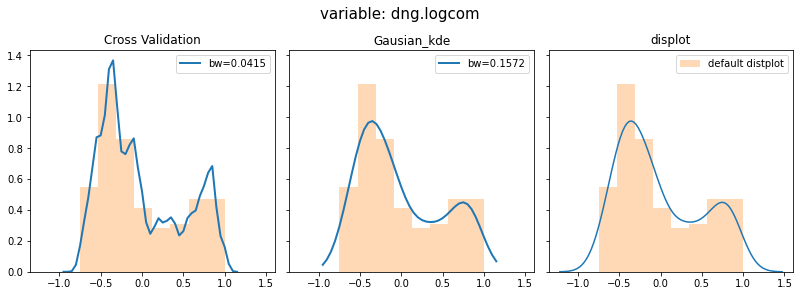

In [78]:
dng_logcom = bw_opt(dhg.logcom, name="dng.logcom", plot=True)

To determine the bw for all data, we can uncomment the following lines.

In [80]:
#%%time
#x_variables = [dng,dlg,dhg,dnt,dlt,dht,dn,dl,dh]
#names       = ["dng","dlg","dhg","dnt","dlt","dht","dn","dl","dh"]
#opt_bw_eff  = [] 
##opt_bw_logcom  = [] 

#for index,variable in enumerate(x_variables):
#    print(names[index]+"."+str(variable.logeff.name))
#    bw = bw_opt(variable.logeff, names[index], plot=True)
#    opt_bw_eff.append(bw)

Nevertheless, the results show overfiting, so, it is nessesary to study the bandwidth problem more thoroughly. We implement a seach vector in order to find the scalar hyperparameter of bandwidth. 

## Optimal bandwidth $bw$ and the PDF

Now, we stablish a better way to determinie the $bw$ and the pdf for each variable. We implement the `KernelDansity` (through `SearchGridCV`) and `gaussian_kde` as methods of a new class `optimal_bw`. Here we will standarize the data, otherwise, variables measured at different scales do not contribute equally to the analysis. It also heps to determine the ideal bandwith in the search vector of `GridSearchCV`. Therefore, 

- **Standarization**: It is another scaling technique where the values are centered around the mean ($\mu=0$) with a unit standard deviation ($\sigma=1$). It is important when we compare measurements that have different units, because equalize the range and/or data variability. The standarization formula, 

\begin{equation}
X^{\prime}=\frac{X-\mu}{\sigma}.
\end{equation}

#### GridSearchCV Method
We use `GridSearchCV` to estimate the otimal bandwidth $bw$. As the best splitting strategy in cross validation, we take cv$=10$, according with documentaction split the data in more grups is not orthodox, because it does not allow the method to learn with a larger data set.

Finally, in the grid search we employ `KernelDensity` with a Gaussian kernel to generate the pdf for the variable with the ideal bw.  

###### The search vector
In the `GridSearchCV` method we use a search vector to determine the optimal bw. The minimum distance between data is the initial value in the serarch vector. As maximum value of serach we use $3\sigma$ of our data (remember that data are standarized). Finally, the number of steps in the search vector is taken as the ideal for the score of `KernelDensity`.   

#### Gaussian_kde  Method
we use this method as is described in the documentation. 

In [14]:
class optimal_bw(object):
    
    def __init__(self, variable):
        
        dx, length, deciamls = .2, 100, 2 #some constants for the grid of space
        self.variable = variable.values   #original variable
        #standarization:
        self.x = (self.variable-self.variable.mean())/self.variable.std()
        #grid in the original variable space:
        self.O_space = np.around(np.linspace(self.variable.min()-dx,
                                             self.variable.max()+dx,length),length)
        #grid in the std space:
        self.x_grid  = np.around(np.linspace(self.x.min()-dx,
                                            self.x.max()+dx,length),length)
        #distance between data
        m = np.abs(np.diff(self.x))      
        self.min = min(m[m>0])
        
    def cv_pdf(self):
        cv, nsteps = 10, 50
        grid = GridSearchCV(KernelDensity(),{'bandwidth': np.linspace(self.min, 
                                                                      3*self.x.std(), 
                                                                      nsteps)}, cv=cv)
        grid.fit(self.x[:, None])
        
        self.bw_CV  = grid.best_estimator_.bandwidth # bw in the standarized space       
        self.bw_1   = self.bw_CV*self.variable.std() # bw in the variable space
        
        self.pdf_CV = np.exp(grid.best_estimator_.score_samples(self.x_grid[:,None]))
        
        #KernelDensity in the variable space with the respective bw
        kde_org = KernelDensity(bandwidth = self.bw_1).fit(self.variable[:, None])
        self.PDF_1 = np.exp(kde_org.score_samples(self.O_space[:, None]))
    
    def kde_pdf(self):
        kde_G = gaussian_kde(self.x)
        
        self.bw_KDE =  kde_G.covariance_factor()      # bw in the standarized space
        self.bw_2 = self.bw_KDE*self.variable.std()   # bw in the variable space
        
        self.pdf_kde = kde_G.evaluate(self.x_grid)
        

So, we implement the methods from `bw_optimal` as, 

In [15]:
ex = optimal_bw(dng.logcom)  #dng.logeff, dng.com, dng.metal
ex.cv_pdf(); 
ex.kde_pdf()

Now, we make a funtion that generates the comparative plot between `gaussian_kde` and `GridSearchCV` methods for get the pdf in the standarized data. 

In [16]:
#needs an object from class bw_optimal
def pdf1D_std(bw, nbins=25):
    lat=12
    fig, ax = plt.subplots(1,2, figsize=(12, 5), constrained_layout=True, sharey=True)

    ax[0].plot(bw.x_grid, bw.pdf_CV, linewidth=2, label='bw=%.3f'%bw.bw_CV)
    ax[0].hist(bw.x, nbins, density=True, alpha=.3, label="standarized data")
    ax[0].legend(loc="upper left", fontsize =lat); ax[0].set_title("KernelDensity", fontsize = lat)

    ax[1].plot(bw.x_grid, bw.pdf_kde, linewidth=2, label='bw=%.3f'%bw.bw_KDE)
    ax[1].hist(bw.x,nbins,density=True, alpha=.3, label="standarized data")
    ax[1].legend(loc="upper left", fontsize=lat)
    ax[1].set_title("Gausian_kde", fontsize=lat)

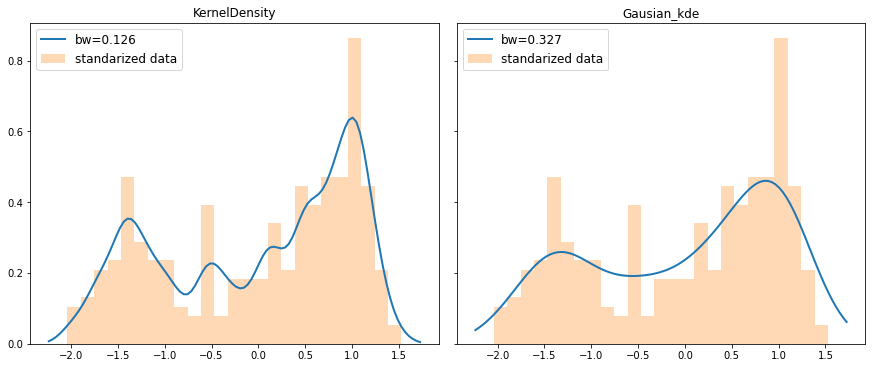

In [17]:
plot = pdf1D_std(ex)

For all the information in the variable `x_variables`

In [18]:
x_variables = [dng,dlg,dhg,dnt,dlt,dht,dn,dl,dh]
#for index,variable in enumerate(x_variables):
#    #print(names[index]+"."+str(variable.logcom.name))
#    bw = optimal_bw(variable.logeff)
#    bw.cv_pdf()
#    bw.kde_pdf()
#    plot = pdfs_plot(bw)

### PDF in the variable space

In order to get the pdf in the variable space, we have two possibilities: 

1. Make an reverse process as standarization for the pdf resulting in tyhe methods of `optimal_bw` class: 

$$X=Z\sigma+\mu$$

Note that in this option we are not interested in bandwidth, just in take the pdf in the original space. 

2. Make the `KernelDensity` and `gaussian_kde` in the variable space, with the respective $bw$ obtained from standar space and transformed to the variable space. The bandwidth in the variable space $bw$ can be determined as,

$$bw=\sigma bw^\prime.$$

Here, the $bw^\prime$ is the bandwidth in the standarized space, $\sigma$ is the standar deviaton for our data. 

**Let's star with the first option:** 

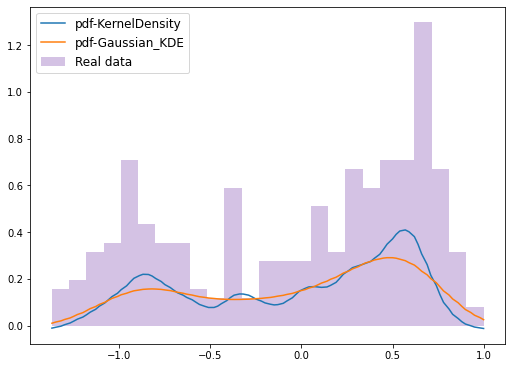

In [19]:
x=np.around(np.linspace(ex.variable.min(),ex.variable.max(),100),2)

#pdf in the data space:
y  = (ex.pdf_CV*ex.variable.std())+ex.variable.mean()
y2 = (ex.pdf_kde*ex.variable.std())+ex.variable.mean()


fig, ax = plt.subplots(1,1, figsize=(7, 5), constrained_layout=True, sharey=True)

ax.plot(x,y, label='pdf-KernelDensity')
ax.plot(x,y2, label='pdf-Gaussian_KDE')
ax.hist(ex.variable, bins=25, color="C4", density=True, alpha =.4, label="Real data")
plt.legend(fontsize=12)

In [20]:
#class optimal_bw_org(optimal_bw):
    
#    def __init__(self, variable):
#        optimal_bw.__init__(self, variable)
#        optimal_bw.cv_pdf(self) 
#        optimal_bw.kde_pdf(self)
#    
#    def des_std(self):
#        self.PDF_org_1 = self.pdf_CV*self.variable.std()+self.variable.mean()
#        self.PDF_org_2 = self.pdf_kde*self.variable.std()+self.variable.mean()

In [21]:
#pdf_org = optimal_bw_org(dlg.logcom)
#pdf_org.des_std()

In [22]:
#needs an object from class bw_optimal_org
#def pdf1D_org(pdf_org, nbins=25):
#    
#    fig, ax = plt.subplots(1,2, figsize=(14, 4), constrained_layout=True, sharey=True)#
#
#    ax[0].plot(pdf_org.O_space, pdf_org.PDF_org_1, 
#               linewidth=2, label='bw=%.3f'%pdf_org.bw_1)
#    ax[0].hist(pdf_org.variable, nbins, density=True, alpha=.3, label="Real data")
#    ax[0].legend(loc="upper left"); ax[0].set_title("KernelDensity")#
#
#    ax[1].plot(pdf_org.O_space,  pdf_org.PDF_org_2, 
#               linewidth=2, label='bw=%.3f'%pdf_org.bw_2)
#    ax[1].hist(pdf_org.variable,nbins,density=True, alpha=.3, label="Real data")
#    ax[1].legend(loc="upper left")
#    ax[1].set_title("Gausian_kde")

In [23]:
#plot = pdf1D_std(ex)
#plot2 = pdf1D_org(pdf_org)

Therfore, the first option fails in the height of the PDF. It is a problem maybe because the traing data was in the standarized space, then when we change it to the original space the "re-scaling" through linear regression does not work.

**Let's study the second option:**

for the second option, we get the $bw^\prime$ which is the bandwidth in the standarized space, to take it to the variable space, 

$$bw=\sigma bw^\prime.$$



In [24]:
#grid in the variable space
x_space = np.around(np.linspace(ex.variable.min(),ex.variable.max(),100),2)

#bw in the variable space
BW_1 = ex.bw_CV*ex.variable.std()
BW_2 = ex.bw_KDE*ex.variable.std()
print(BW_1,BW_2)

#pdf in the original space with the ideal bw employing Kernel Density
kde_1d = KernelDensity(bandwidth = BW_1).fit(ex.variable[:, None])
PDF_1  = np.exp(kde_1d.score_samples(x_space[:, None]))

#pdf in the original space with the ideal bw employing Gaussian_KDE
kde_G1d = gaussian_kde(ex.variable, bw_method = BW_2)
PDF_2   = kde_G1d.evaluate(x_space)

0.08389739852553774 0.2173471509485891


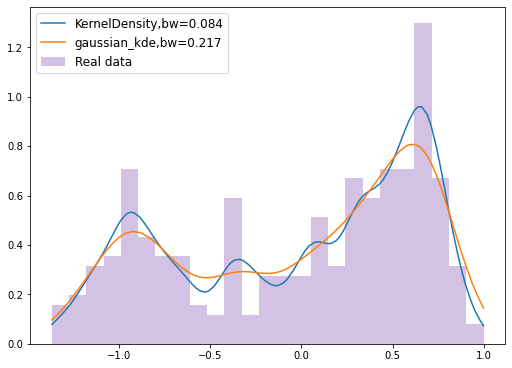

In [25]:
fig, ax = plt.subplots(1,1, figsize=(7, 5), constrained_layout=True, sharey=True)

ax.hist(ex.variable, bins=25, color="C4", density=True, alpha =.4, label="Real data")
plt.plot(x_space,PDF_1, label ="KernelDensity," + "bw=%.3f"%BW_1)
plt.plot(x_space,PDF_2, label ="gaussian_kde," + "bw=%.3f"%BW_2)

plt.legend(fontsize=12)

## Bandwiths for  2-D and 3-D
We are going to study the bw problem for more than one dimension

### 2D Example
For 2d, we have the function:

In [26]:
def uni_kde(x,y,tickno=5,nlev=30):
    
    x_grid=np.around(np.arange(x.min(),x.max(),0.1),2)
    y_grid=np.linspace(y.min(),y.max(),len(x_grid))
    conv=(x.max()-x.min())/(y.max()-y.min())
    yori=y
    y=y*conv
    y_grid=y_grid*conv
    
    grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(x.min(),x.max()/10,50)},
                    cv=20) # 20-fold cross-validation
    
    grid.fit(np.vstack([x,y]).T)
    
    print(grid.best_params_)
    
    X, Y = np.meshgrid(x_grid, y_grid)
  
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    
    kde2d = grid.best_estimator_
    pdf2d = np.exp(kde2d.score_samples(xy)).reshape(X.shape) #get the pdf
    
    plt.figure(figsize=(5,5))
    levels = np.linspace(0, pdf2d.max(), nlev)
    plt.contourf(X, Y, pdf2d, levels=levels, cmap=plt.cm.Reds)
    
    old_ticks=np.linspace(y.max(), y.min(), tickno)
    major_ticks = 10**np.linspace(yori.max(), yori.min(), tickno)
    myticks=[]
    for i in major_ticks:
        myticks+=["%.e"%i]
    e=plt.yticks(old_ticks,myticks) 

similar function that has standarized data and emply the methods in the class `optimal_bw`

In [27]:
#needs two objects from class bw_optimal, which are normalized or standarized 
def bi_kde(data_x,data_y):
    
    x_grid = data_x.x_grid
    y_grid = data_y.x_grid
    m = [data_x.min,data_y.min]
    
    #grid = KernelDensity() # para hacer pruebas
    
    grid = GridSearchCV(KernelDensity(), 
                        {'bandwidth': np.linspace(min(m),
                                                  3*data_x.x.std(),
                                                  50)}, cv=10)
    #xx = np.vstack([data_x.x,data_y.x]).T
    #print(len(xx))
    grid.fit(np.vstack([data_x.x,data_y.x]).T)
    print(grid.best_params_)
    
    X, Y = np.meshgrid(x_grid, y_grid)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    #print(len(xy))
    kde2d = grid.best_estimator_
    pdf2d = np.exp(kde2d.score_samples(xy)).reshape(X.shape) #get the pdf
    
    plt.figure(figsize=(5,5))
    plt.contourf(X, Y, pdf2d, levels=30, cmap=plt.cm.Reds)
    
    return pdf2d

{'bandwidth': 0.09996864449290914}
{'bandwidth': 0.24846383182056772}


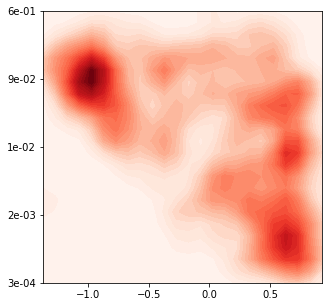

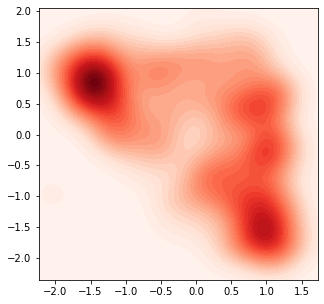

In [28]:
uni_kde(dng.logcom, dng.logeff)
ex_2d = bi_kde(optimal_bw(dng.logcom),optimal_bw(dng.logeff))

### 3D example

Just an example with 3 variables, without standardized and standarized data. 

In [29]:
from mpl_toolkits import mplot3d
#---------------------Data:
x = dng.logeff/dng.logeff.min()
y = dng.logcom#/dng.logcom.min()
z = dng.nplanets

data = np.vstack((x,y,z)).T
#---------------------Grid:
x_grid=np.around(np.linspace(x.min(),x.max(),30),2)
y_grid=np.linspace(y.min(),y.max(),len(x_grid))
z_grid=np.linspace(z.min(),z.max(),len(x_grid))

X,Y,Z = np.meshgrid(x_grid, y_grid, z_grid)
xyz   = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T
#----------------------CV:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(x.min(),x.max()/10,30)},
                    cv=20) # 20-fold cross-validation
grid.fit(data)
    
kde3d_1 = grid.best_estimator_
pdf3d_1 = np.exp(kde3d_1.score_samples(xyz)).reshape(X.shape) #get the pdf

In [30]:
density_1 = pdf3d_1.ravel()
#fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
#x, y, z = X.ravel(), Y.ravel(), Z.ravel()
#ax.scatter(x, y, z, c=density_1, alpha=1, cmap= 'seismic',
#           vmin=-np.abs(np.max(density_1)),vmax=np.abs(np.max(density_1)))

In [31]:
#import plotly.graph_objects as go
#fig = go.Figure(data=go.Volume(
#    x=X.flatten(),
#    y=Y.flatten(),
#    z=Z.flatten(),
#    value=density_1.flatten(),
#    opacity=0.1, # needs to be small to see through all surfaces
#    surface_count=25, # needs to be a large number for good volume rendering
#    ))
#fig.show()

In [32]:
#---------------------Data:
x2 = (dng.logeff-dng.logeff.mean())/dng.logeff.std()
y2 = (dng.logcom-dng.logcom.mean())/dng.logcom.std()
z2 = (dng.nplanets-dng.nplanets.mean())/dng.nplanets.std()
#z2 = dng.nplanets

data2 = np.vstack([x2,y2,z2]).T

#---------------------Grid:
x2_grid=np.around(np.linspace(x2.min(),x2.max(),30),2)
y2_grid=np.linspace(y2.min(),y2.max(),len(x2_grid))
z2_grid=np.linspace(z2.min(),z2.max(),len(x2_grid))

X2,Y2,Z2 = np.meshgrid(x2_grid, y2_grid, z2_grid)
xyz2   = np.vstack([X2.ravel(), Y2.ravel(), Z2.ravel()]).T


m=np.abs(np.diff([x2,y2,z2]))        #distance between data
var_min=min(m[m>0])

#----------------------CV:

grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(var_min,3*x2.std(),50)},
                    cv=20) # 20-fold cross-validation
grid.fit(data2)

kde3d_2 = grid.best_estimator_
pdf3d_2 = np.exp(kde3d_2.score_samples(xyz2)).reshape(Z2.shape) #get the pdf

In [33]:
len(data2)

268

A comparative plot, employing `plotly`.

In [34]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
'''
density_2 = pdf3d_2.ravel()

fig = make_subplots(rows=1, cols=2,  
                    specs=[[{'type': 'volume'}, {'type': 'volume'}]])

fig.add_trace(
    
    go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=density_1.flatten(),
    opacity=0.1,     # needs to be small to see through all surfaces
    surface_count=25 # needs to be a large number for good volume rendering
    ), 
    row=1, col=1
)
fig.update_layout(height=500, showlegend=False)

fig.add_trace(
    
    go.Volume(
    x=X2.flatten(),
    y=Y2.flatten(),
    z=Z2.flatten(),
    value=density_2.flatten(),
    opacity=0.1,     # needs to be small to see through all surfaces
    surface_count=25 # needs to be a large number for good volume rendering
    ), 
    row=1, col=2
)
fig.update_layout(height=500, showlegend=False)
fig.show()
'''

"\ndensity_2 = pdf3d_2.ravel()\n\nfig = make_subplots(rows=1, cols=2,  \n                    specs=[[{'type': 'volume'}, {'type': 'volume'}]])\n\nfig.add_trace(\n    \n    go.Volume(\n    x=X.flatten(),\n    y=Y.flatten(),\n    z=Z.flatten(),\n    value=density_1.flatten(),\n    opacity=0.1,     # needs to be small to see through all surfaces\n    surface_count=25 # needs to be a large number for good volume rendering\n    ), \n    row=1, col=1\n)\nfig.update_layout(height=500, showlegend=False)\n\nfig.add_trace(\n    \n    go.Volume(\n    x=X2.flatten(),\n    y=Y2.flatten(),\n    z=Z2.flatten(),\n    value=density_2.flatten(),\n    opacity=0.1,     # needs to be small to see through all surfaces\n    surface_count=25 # needs to be a large number for good volume rendering\n    ), \n    row=1, col=2\n)\nfig.update_layout(height=500, showlegend=False)\nfig.show()\n"

## Multidimensional case

It is time to obtain the bw and the PDF for any dimensionality. At this point, we use the `GridSearchCV` for the `KernelDensity` method, to obtain the ideal bw and the PDF function. 

The search vector has the same the same spirit: an initial value which is the minimum disntance betweeen the data and 3 times the standard deviation of our normalized data. Finally, the number of steps in the search vector is taken as the ideal for the optimal score of `KernelDensity`. 

Again, we will use as the best splitting strategy in cross validation cv$=10$.

In [35]:
class multidim_bw(object):

    def __init__(self, *args):
        
        self.dim = len(args)
        dx, length, deciamls = .2, 30, 2  # some constants for the grid of space
        self.diffmin, self.var_grids, self.var_values  = [], [], [] 
        self.means, self.stds = [],[]       # original values of mean and std.
        
        self.var_grids2 = []
        
        for i in range(len(args)):        
            self.means.append(args[i].values.mean())
            self.stds.append(args[i].values.std())
            
            # standarization:
            self.x = (args[i].values - self.means[i]) / self.stds[i] 
            self.var_values.append(self.x)
            # grids:
            self.var_grids.append(np.around(np.linspace(self.x.min()-dx,
                                                        self.x.max()+dx,
                                                        length),deciamls))
            self.var_grids2.append(np.around(np.linspace(args[i].values.min()-dx,
                                                         args[i].values.max()+dx,
                                                         length),deciamls))
            # Distance between data (dx):
            m = np.abs(np.diff(self.x))     
            self.diffmin.append(min(m[m>0]))
            
        self.data   = np.vstack([*self.var_values]).T 
        
        self.n_grid = np.meshgrid(*self.var_grids) #PROBLEM MEMORY FOR 5D,6D... nD.
        self.n_grid2 = np.meshgrid(*self.var_grids2) #PROBLEM MEMORY FOR 5D,6D... nD.
        #self.n_grid = np.meshgrid(*self.var_grids2) #PROBLEM MEMORY FOR 5D,6D... nD.
        
        # It generates the space for the pdf
        ll = [self.n_grid[i].ravel() for i in range(len(self.n_grid))]
        ll_2 = [self.n_grid2[i].ravel() for i in range(len(self.n_grid2))]

        self.space  = np.vstack([*ll]).T   
        self.space2  = np.vstack([*ll_2]).T   

    def pdf_ndim(self):
        ideal=50
        self.grid = GridSearchCV(KernelDensity(),
                                 {'bandwidth': np.linspace(min(self.diffmin), 
                                                           3*self.x.std(),
                                                           ideal)}, cv=10)
        self.grid.fit(self.data)
        self.ndim_bw  = self.grid.best_estimator_.bandwidth
        
        self.pdf_std = np.exp(self.grid.best_estimator_.score_samples(self.space))#.reshape(self.n_grid[0].shape))  #get the pdf
        self.ndim_pdf = self.pdf_std.reshape(self.n_grid[0].shape)

In [36]:
ex2 = multidim_bw(dng.logeff, dng.logcom, dng.nplanets)
ex2.pdf_ndim()

In [37]:
ex2.stds

[0.8095864069754978, 0.664937629029433, 3.0335683207265873]

Let's to change the space to the variable space. To do this, we make the inverse process of standarization:

In [38]:
#reshape the standar pdf
pdf_std = ex2.pdf_std.reshape(int(len(ex2.space)/ex2.dim), ex2.dim)
pdf_std

array([[2.36249533e-07, 2.71753807e-07, 1.07410214e-07],
       [1.45874973e-08, 6.80740024e-10, 9.43087897e-12],
       [6.87229835e-14, 7.97481427e-14, 1.73027996e-13],
       ...,
       [5.58585956e-11, 1.17101951e-11, 9.37586706e-13],
       [2.59200680e-14, 2.46285691e-16, 8.05733228e-19],
       [1.30108246e-20, 3.10761680e-20, 2.74054052e-20]])

In [39]:
#original pdf
pdf_original = (pdf_std*ex2.stds)-ex2.means
pdf_original

array([[  1.73672292,   0.01524128, -11.39925341],
       [  1.73672274,   0.0152411 , -11.39925373],
       [  1.73672273,   0.0152411 , -11.39925373],
       ...,
       [  1.73672273,   0.0152411 , -11.39925373],
       [  1.73672273,   0.0152411 , -11.39925373],
       [  1.73672273,   0.0152411 , -11.39925373]])

In [40]:
pdf_original = ex2.pdf_std.reshape(int(len(ex2.space)/ex2.dim), ex2.dim) 
pdf_original = (pdf_original*ex2.stds)-ex2.means
AA = pdf_original.ravel()

In [41]:
#fig = go.Figure(data=go.Volume(
#    x=ex2.n_grid2[0].flatten(),
#    y=ex2.n_grid2[1].flatten(),
#    z=ex2.n_grid2[2].flatten(),
#    value=AA.flatten(),
#    opacity=0.1, # needs to be small to see through all surfaces
#    surface_count=30, # needs to be a large number for good volume rendering
#    ))
#fig.show()

My solution, apply the bandwidth obteined from the standarized space, but converted to the original space and make `KernelDensity`, with the original data and this bandwidth. Then, calculate the pdf for a grid in the original space

In [42]:
BW_3d = ex2.ndim_bw*max(ex2.stds)

In [43]:
data = np.vstack([dng.logeff, dng.logcom, dng.nplanets]).T

kde = KernelDensity(bandwidth=BW_3d).fit(data) 

PDF = np.exp(kde.score_samples(ex2.space2))

In [44]:
#fig = go.Figure(data=go.Volume(
#    x=ex2.n_grid2[0].flatten(),
#    y=ex2.n_grid2[1].flatten(),
#    z=ex2.n_grid2[2].flatten(),
#    value=PDF.flatten(),
#    opacity=0.1, # needs to be small to see through all surfaces
#    surface_count=30, # needs to be a large number for good volume rendering
#    ))
#fig.show()

Due to call `numpy.meshgrid` requires a lot of memory, a n_dimentional grid will require a lot of  memory tooa and will produce a **MemoryError**, for that reason we only get the pdf for 3-dimentions. 

therfore, we determine the "functional" form of our pdf through `GridSearchCV.fit()`. Then, we determine a pdf for variables that we know using `numpy.exp(GridSearchCV.best_estimator_.score_samples(xxxx))`, where `xxxx` represents the known data. This way to work is the same as if we marginalize the n_dimentional pdf  over the unknown variables. 

In [45]:
%%time
ex2 = multidim_bw(dng.logeff, dng.logcom, dng.nplanets)#, dng.metal, dng.massefficiency)

CPU times: user 3.72 ms, sys: 13 µs, total: 3.74 ms
Wall time: 3.27 ms


As a result we have the same information that 

In [46]:
#fig = go.Figure(data=go.Volume(
#    x=ex3.n_grid[0].flatten(),
#    y=ex3.n_grid[1].flatten(),
#    z=ex3.n_grid[2].flatten(),
#    value=ex3.ndim_pdf.flatten(),
#    opacity=0.1, # needs to be small to see through all surfaces
#    surface_count=30, # needs to be a large number for good volume rendering
#    ))
#fig.show()

# Posterior distribution and Marginalization

Let's study  the prior distribution and the respective marginalization of an interest variable. To do this, we employ the observations as prior information, as likelihoog, we take the pdf obtained from `KernelDensity` and the bandwidth problem. The respective product will be the posterior distribution. 

In [47]:
dim = 30 

In [48]:
example = multidim_bw(dng.logeff, dng.logcom, dng.nplanets)
example.pdf_ndim()

In [49]:
BW_example = example.ndim_bw*max(example.stds)

data_example = np.vstack([dng.logeff, dng.logcom, dng.nplanets]).T

kde_example = KernelDensity(bandwidth=BW_example).fit(data_example) 

PDF_example = np.exp(kde_example.score_samples(example.space2))

In [50]:
likelihood = PDF_example.reshape(example.n_grid2[0].shape) 

print(likelihood.shape)
#print(example.pdf_ndim().ndim_bw)

(30, 30, 30)


As prior we define a noise 2d matrix

In [51]:
prior = np.eye(dim,dim)

The posterior is proportonal to the product of: 

In [52]:
posterior=likelihood*prior

#fig = go.Figure(data=go.Volume(
#    x=example.n_grid[0].flatten(),
#    y=example.n_grid[1].flatten(),
#    z=example.n_grid[2].flatten(),
#    value=posterior.flatten(),
#    opacity=0.1, # needs to be small to see through all surfaces
#    surface_count=30, # needs to be a large number for good volume rendering
#    ))
#fig.show()

Then we take the sum over other variables which are not of interest 

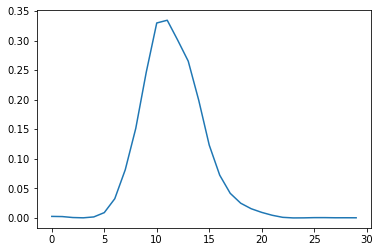

In [53]:
post = np.sum(np.sum(posterior, axis=0), axis=0)
plt.plot(post)

In [54]:
#post_2=np.einsum('xyz,xy->z',likelihood, prior)

In [55]:
#ex = optimal_bw(dng.nplanets)#dng.logeff, dng.com, dng.metal
#ex.cv_pdf();ex.kde_pdf()
#pdf1D_std(ex)

Now we make a new class for obtain the bandwidth $bw$ in the standarized space, then pass it to the variable space and make the pdf employing `KernelDensity`.

In [56]:
class optimal_pdf(object):

    def __init__(self, *args):
        
        self.dim  = len(args)
        self.data = np.vstack([*args]).T
        #Standarization
        self.data_std = (self.data-np.mean(self.data, axis=0))\
                        /np.std(self.data, axis=0)
    
    def bw(self):
        # Variables:
        lenght, size, deciamls, ds , cv = 50, 30, 2, .2, 10  
    
        # Grids:
        self.std_grids = []             
        for i in range(self.dim):
            self.std_grids.append(np.around(np.linspace(self.data_std[:,i].min()-ds,
                                                        self.data_std[:,i].max()+ds,
                                                        size),deciamls))
        n_grid = np.meshgrid(*self.std_grids) #PROBLEM MEMORY FOR 5D,6D... nD.
        
        #bandwidth_std
        V_search = {'bandwidth':np.linspace(abs(self.data_std).min(), 
                                            3*self.data_std.std(), lenght)}
        
        grid_std = GridSearchCV(KernelDensity(),V_search, cv = cv).fit(self.data_std)
        bw_std  = grid_std.best_estimator_.bandwidth
        
        #bandwidth_real
        self.bw = bw_std*abs(np.std(self.data, axis=0)).max()
        
        return self.bw
    
    def pdf(self):
        
        ideal= 5; self.bw()
        kde  = KernelDensity(bandwidth=self.bw).fit(self.data) 
        
        self.pdf = np.exp(kde.score_samples(example.space2))
                            
    
    
    ll = [self.n_grid[i].ravel() for i in range(len(self.n_grid))]
        ll_2 = [self.n_grid2[i].ravel() for i in range(len(self.n_grid2))]

        self.space  = np.vstack([*ll]).T   
        self.space2  = np.vstack([*ll_2]).T   
    
    
    
    
    
    
    '''     
    self.grid = GridSearchCV(KernelDensity(),
                                 {'bandwidth': np.linspace(min(self.diffmin), 
                                                           3*self.x.std(),
                                                           ideal)}, cv=10)
        self.grid.fit(self.data)
        self.ndim_bw  = self.grid.best_estimator_.bandwidth
        
        self.pdf_std = np.exp(self.grid.best_estimator_.score_samples(self.space))#.reshape(self.n_grid[0].shape))  #get the pdf
        self.ndim_pdf = self.pdf_std.reshape(self.n_grid[0].shape)
        
        
        
            self.var_grids2.append(np.around(np.linspace(args[i].values.min()-dx,
                                                         args[i].values.max()+dx,
                                                         length),deciamls))
            # Distance between data (dx):
            m = np.abs(np.diff(self.x))     
            self.diffmin.append(min(m[m>0]))
            
        self.data   = np.vstack([*self.var_values]).T 
        
        self.n_grid = np.meshgrid(*self.var_grids) #PROBLEM MEMORY FOR 5D,6D... nD.
        self.n_grid2 = np.meshgrid(*self.var_grids2) #PROBLEM MEMORY FOR 5D,6D... nD.
        #self.n_grid = np.meshgrid(*self.var_grids2) #PROBLEM MEMORY FOR 5D,6D... nD.
        
        # It generates the space for the pdf
        ll = [self.n_grid[i].ravel() for i in range(len(self.n_grid))]
        ll_2 = [self.n_grid2[i].ravel() for i in range(len(self.n_grid2))]

        self.space  = np.vstack([*ll]).T   
        self.space2  = np.vstack([*ll_2]).T   
    
       
    def bw(self):
        lenght  = 50
        V_serch = {'bandwidth':np.linspace(min(self.diffmin), 3*self.x.std(), lenght)}
        self.grid_std
        
        self.grid.fit(self.data)
    
        
    def pdf(self):
        ideal=50
        self.grid = GridSearchCV(KernelDensity(),
                                 {'bandwidth': np.linspace(min(self.diffmin), 
                                                           3*self.x.std(),
                                                           ideal)}, cv=10)
        self.grid.fit(self.data)
        self.ndim_bw  = self.grid.best_estimator_.bandwidth
        
        self.pdf_std = np.exp(self.grid.best_estimator_.score_samples(self.space))#.reshape(self.n_grid[0].shape))  #get the pdf
        self.ndim_pdf = self.pdf_std.reshape(self.n_grid[0].shape)
        ''' 

IndentationError: unexpected indent (<ipython-input-56-ebea4fc952c9>, line 45)

In [ ]:
AA = optimal_pdf(dng.logcom)
AA.bw()

In [ ]:
AA.std_grids

In [ ]:
class multidim_bw(object):

    def __init__(self, *args):
        
        self.dim = len(args)
        dx, length, deciamls = .2, 60, 2  # some constants for the grid of space
        self.diffmin, self.var_grids, self.var_values  = [], [], [] 
        self.means, self.stds = [],[]       # original values of mean and std.
        
        self.var_grids2 = []
        
        for i in range(len(args)):        
            self.means.append(args[i].values.mean())
            self.stds.append(args[i].values.std())
            
            # standarization:
            self.x = (args[i].values - self.means[i]) / self.stds[i] 
            self.var_values.append(self.x)
            # grids:
            self.var_grids.append(np.around(np.linspace(self.x.min()-dx,
                                                        self.x.max()+dx,
                                                        length),deciamls))
            self.var_grids2.append(np.around(np.linspace(args[i].values.min()-dx,
                                                         args[i].values.max()+dx,
                                                         length),deciamls))
            # Distance between data (dx):
            m = np.abs(np.diff(self.x))     
            self.diffmin.append(min(m[m>0]))
            
        self.data   = np.vstack([*self.var_values]).T 
        
        self.n_grid = np.meshgrid(*self.var_grids) #PROBLEM MEMORY FOR 5D,6D... nD.
        self.n_grid2 = np.meshgrid(*self.var_grids2) #PROBLEM MEMORY FOR 5D,6D... nD.
        #self.n_grid = np.meshgrid(*self.var_grids2) #PROBLEM MEMORY FOR 5D,6D... nD.
        
        # It generates the space for the pdf
        ll = [self.n_grid[i].ravel() for i in range(len(self.n_grid))]
        ll_2 = [self.n_grid2[i].ravel() for i in range(len(self.n_grid2))]

        self.space  = np.vstack([*ll]).T   
        self.space2  = np.vstack([*ll_2]).T   

    def pdf_ndim(self):
        ideal=50
        self.grid = GridSearchCV(KernelDensity(),
                                 {'bandwidth': np.linspace(min(self.diffmin), 
                                                           3*self.x.std(),
                                                           ideal)}, cv=10)
        self.grid.fit(self.data)
        self.ndim_bw  = self.grid.best_estimator_.bandwidth
        
        self.pdf_std = np.exp(self.grid.best_estimator_.score_samples(self.space))#.reshape(self.n_grid[0].shape))  #get the pdf
        self.ndim_pdf = self.pdf_std.reshape(self.n_grid[0].shape)

## Real example 
For example we take the aviable information of exoplanet system **TRAPPIST-1** as prior information. As likelihoood, the pdf from no preturvations systems, low perturbation systems and high perturbation systems. 

In [ ]:
data =  pd.read_csv('data/exoplanet.eu_catalog.csv')
TRAPPIST_1 = data[data.star_name == "TRAPPIST-1"]   
TRAPPIST_1.head()

Aleatory standarized values for the center of mass and the metallicity of the system **TRAPPIST_1**

In [ ]:
#standarize
#Mtp = (TRAPPIST_1.mass-TRAPPIST_1.mass.mean())/TRAPPIST_1.mass_error_min.mean()
#TRAPPIST_std =(TRAPPIST_1-TRAPPIST_1.mean())/TRAPPIST_1.std()

In [ ]:
#TRAPPIST_std =(TRAPPIST_1-TRAPPIST_1.mean())/TRAPPIST_1.std()
#Mt = TRAPPIST_std.mass.sum()
#Metal = TRAPPIST_std.star_metallicity
#CoM = (TRAPPIST_std.mass*TRAPPIST_std.semi_major_axis)/Mt
#CoM_1 = np.random.normal(CoM.mean(),CoM.std(),(30))
#Met = np.random.normal(TRAPPIST_std.star_metallicity.mean(),
#                       TRAPPIST_std.star_metallicity_error_min.mean(), (30))

In [ ]:
mean = [TRAPPIST_1.mass.mean(),TRAPPIST_1.star_metallicity.mean()]
cov  = [[TRAPPIST_1.mass_error_min.mean(),0],
        [0,TRAPPIST_1.star_metallicity_error_min.mean()]]
prior_1 = np.random.multivariate_normal(mean, cov, (dim,dim))
prior_1.shape

However, the `np.random.multivariate_normal`, generates a different shape for data. So let's suppose that we know the functional form of the prior, as the following function shows:

In [ ]:
def bi_norm(x, y, x_mu, x_std, y_mu, y_std):
    c = 1/(2*np.pi*x_std*y_std)
    return c*np.exp(-((x-x_mu)/x_std)**2-((y-y_mu)/y_std)**2)

In [ ]:
x = np.linspace(-3*TRAPPIST_1.mass_error_min.mean(),3*TRAPPIST_1.mass_error_min.mean(),dim)
y = np.linspace(-3*TRAPPIST_1.star_metallicity_error_min.mean(),
                3*TRAPPIST_1.star_metallicity_error_min.mean(),dim)

X,Y=np.meshgrid(x,y)

As a result we get the prior

In [ ]:
#Falta marginalizar 

prior_2 = bi_norm(X,Y,
                  TRAPPIST_1.mass.mean(),
                  TRAPPIST_1.mass_error_min.mean(),
                  TRAPPIST_1.star_metallicity.mean(),
                  TRAPPIST_1.star_metallicity_error_min.mean())

prior_2.shape

Now the likelihood:

In [ ]:
#like = multidim_bw(dng.com, dng.metal, dng.ms)
#like.pdf_ndim()
likelihood_2 = PDF.reshape(ex2.n_grid[0].shape) 

In [ ]:
#fig = go.Figure(data=go.Volume(
#    x=like.n_grid[0].flatten(),
#    y=like.n_grid[1].flatten(),
#    z=like.n_grid[2].flatten(),
#    value=likelihood_2.flatten(),
#    opacity=0.1, # needs to be small to see through all surfaces
#    surface_count=30, # needs to be a large number for good volume rendering
#    ))
#fig.show()

The posterior

In [ ]:
posterior_2 = likelihood_2*prior_2

#fig = go.Figure(data=go.Volume(
#    x=like.n_grid[0].flatten(),
#    y=like.n_grid[1].flatten(),
#    z=like.n_grid[2].flatten(),
#    value=posterior_2.flatten(),
#    opacity=0.1, # needs to be small to see through all surfaces
#    surface_count=30, # needs to be a large number for good volume rendering
#    ))
#fig.show()

The marginal distribution over the mass disk

In [ ]:
#Marginal_md=np.einsum('xyz,xy->z',likelihood_2, prior_2)
#plt.plot(Marginal_md)#, kde_kws={"bw":0.309})

In [ ]:
marginal_md = np.sum(np.sum(posterior_2, axis=0), axis=1)
#sns.distplot(marginal_md, hist=False)
plt.plot(marginal_md)